In [61]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime

import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from pandas.tseries.offsets import *

In [62]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


In [63]:
#
# random time series
#
date = pd.date_range(start='2015-01', end='2015-05', freq='D')
price = np.random.randint(-100, 100, size=len(date))
df = pd.DataFrame(price, index=date, columns=['close'])
df = df.cumsum()

In [64]:
#
# Real ticker data
#
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

price_data = data.DataReader('SPY', 'yahoo', start, end)
adjclose_series = price_data['Adj Close']
adjclose_series.name = 'close'

df = pd.DataFrame(adjclose_series)

In [540]:
strategyname = 'strategy_440143'
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')

df = pd.DataFrame()
df['close'] = d.exo

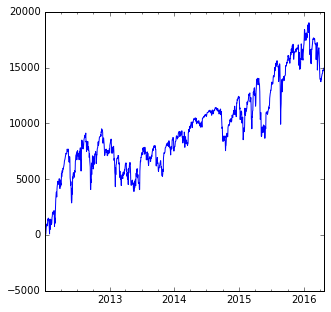

In [541]:
figsize(5,5)
d.exo.plot()

In [542]:
info

{'legs': 3,
 'margin': 2750,
 'name': 'BearishVolStrangle',
 'pcf': array([1, 2, 0], dtype=uint8),
 'pcfqty': array([-1,  0, -1], dtype=int16),
 'tickincrement': 5.0000000000000002e-05,
 'tickvalue': 6.25,
 'underlying': 'EU6'}

## Renko calculation

## High/Low of renko bricks is only needed for visual representation

In [543]:
box_size = 200

box_start = 0
box_start_idx = None

box_end = 0
box_quantity = 0

temp_l = []

# Simple renko algorihtm


# 
for i in range(len(df)):
    if box_start == 0:
        box_start = df.close[i]

    else:
        box_start = box_start
        price_move = df.close[i] - box_start
        
        # First of all we need to set box size. 
        # Then calculate price movement. 
        # If price movement is more or equal than box size - renko bar(or bars) will be added
        
        if np.abs(price_move) >= box_size:
            
            # After we calculate box_quantity(price move divided by box size)
            # This number defines how much renko bars will be registred
            box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
            box_index = df.close.index[i]

            for b in range(int(box_quantity)):
            # Let say, index is 2015-01-01, box_start = 100, box_quantity = 3, box size = 10, price move > 0
            # So renko bar 1 will have next parameters - 
            # 1)index 2015-01-01
            # 2)open = 100
            # 3)close = 110(box_start + box_size)
            # 4)type = up
            
            # Next renko bar will have next parameters -
            # 1)index 2015-01-01
            # 2)open = 110(previous renko bar close)
            # 3)close = 120(open + box_size)
            # 4)type = up
            
            # And so on..
            
            # After all we adding renko bars dict to list and convert it to DF
            
                if price_move > 0:
                    if box_end == 0:
                        d = {'date': box_index, 'open': box_start, 'close': box_start + box_size, 'type': 'up'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:
                        d = {'date': box_index, 'open': box_end, 'close': box_end + box_size,
                            'type': 'up'}
                        
                        box_end = d['close']
                        temp_l.append(d)

                if price_move < 0:
                    if box_end == 0:
                        d = {'date': box_index, 'open': box_start, 'close': box_start - box_size, 'type': 'down'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:           
                        d = {'date': box_index, 'open': box_end, 'close': box_end - box_size, 
                             'type': 'down'}
                        
                        box_end = d['close']
                        temp_l.append(d)
                        
            box_start = df.close[i]
            
renko_df = pd.DataFrame(temp_l)

del temp_l

high_l = []
low_l = []
for i in range(len(renko_df)):
    if renko_df.close[i] > renko_df.open[i]:
        high_l.append(renko_df.close[i])
        low_l.append(renko_df.open[i])
        
    if renko_df.close[i] < renko_df.open[i]:
        high_l.append(renko_df.open[i])
        low_l.append(renko_df.close[i])
        
renko_df['low'] = low_l
renko_df['high'] = high_l

del low_l
del high_l

## Defining peaks and falls and their prices

In [544]:
# Peaks
renko_peak = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') 
          & (renko_df.type.shift(2) == 'up') & (renko_df.type.shift(3) == 'up'))

renko_df['peak'] = renko_peak

# Adding underlying_pick_price column
ul_peak_price = df.close[df.close.index.isin(renko_df[renko_df.peak.shift(-2) == True].date)]
ul_peak_price.name = 'underlying_peak_price'

renko_df = renko_df.join(ul_peak_price, on=['date'])
renko_df.underlying_peak_price = renko_df.underlying_peak_price.shift(2) #This needed for avoiding future reference problem

renko_df.loc[renko_df.peak == False, 'underlying_peak_price'] = np.NaN # Drop all values which available earlier than peak/fall occurs

renko_df['renko_peak_price'] = renko_df.close[renko_df.peak.shift(-2) == True]
renko_df.renko_peak_price = renko_df.renko_peak_price.shift(2) #This needed for avoiding future reference problem

In [545]:
# Falls
renko_fall = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') 
          & (renko_df.type.shift(2) == 'down') & (renko_df.type.shift(3) == 'down'))

renko_df['fall'] = renko_fall

# Adding underlying_fall_price column 
ul_fall_price = df.close[df.close.index.isin(renko_df[renko_df.fall.shift(-2) == True].date)]
ul_fall_price.name = 'underlying_fall_price'

renko_df = renko_df.join(ul_fall_price, on=['date'])
renko_df.underlying_fall_price = renko_df.underlying_fall_price.shift(2) #This needed for avoiding future reference problem

renko_df.loc[renko_df.fall == False, 'underlying_fall_price'] = np.NaN # Drop all values which available earlier than peak/fall occurs

renko_df['renko_fall_price'] = renko_df.close[renko_df.fall.shift(-2) == True]
renko_df.renko_fall_price = renko_df.renko_fall_price.shift(2) #This needed for avoiding future reference problem

renko_df = renko_df.fillna(method='ffill')

## Flat and trend patterns

In [546]:
renko_flat = (((renko_df.type == 'up') & (renko_df.type.shift(1) == 'down') 
                & (renko_df.type.shift(2) == 'up') & (renko_df.type.shift(3) == 'down')) | 
              ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'down') 
             & (renko_df.type.shift(3) == 'up')))

renko_df['flat'] = renko_flat

renko_trend_up = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'up'))
renko_trend_down = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') & (renko_df.type.shift(2) == 'down'))

renko_df['trend_up'] = renko_trend_up
renko_df['trend_down'] = renko_trend_down

## Small double top/bottom pattern

In [547]:
renko_small_double_top = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') & (renko_df.type.shift(2) == 'up')
                         & (renko_df.type.shift(3) == 'down') & (renko_df.type.shift(4) == 'up') & (renko_df.type.shift(5) == 'up'))

renko_df['small_double_top'] = renko_small_double_top

renko_small_double_bottom = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'down')
                         & (renko_df.type.shift(3) == 'up') & (renko_df.type.shift(4) == 'down') & (renko_df.type.shift(5) == 'down'))

renko_df['small_double_bottom'] = renko_small_double_bottom

## Trend correction pattern( no.7 in renko patterns.pdf)

In [548]:
renko_up_trend_correction = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'down')
                            & (renko_df.type.shift(3) == 'up') & (renko_df.type.shift(4) == 'up'))

renko_df['up_trend_correction'] = renko_up_trend_correction

renko_down_trend_correction = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') & (renko_df.type.shift(2) == 'up')
                            & (renko_df.type.shift(3) == 'down') & (renko_df.type.shift(4) == 'down'))

renko_df['down_trend_correction'] = renko_down_trend_correction

# Peak/fall prices combinations

### Defining peak/fall price direction relative to previous peak/fall price

In [549]:
renko_peak_df = renko_df[renko_df.peak == True]

renko_peak_price_move = np.array([None] * len(renko_peak_df.type))
#renko_peak_price_move = np.empty_like(renko_peak_df.type) # This code crashes the python...

for i in range(len(renko_peak_df)):
    if i > 0:
        if renko_peak_df.renko_peak_price.values[i] > renko_peak_df.renko_peak_price.values[i-1]: 
            renko_peak_price_move[i] = 'up'
            
        elif renko_peak_df.renko_peak_price.values[i] < renko_peak_df.renko_peak_price.values[i-1]:
            renko_peak_price_move[i] = 'down'
            
        elif renko_peak_df.renko_peak_price.values[i-1] == renko_peak_df.renko_peak_price.values[i]:
            renko_peak_price_move[i] = 'same'

renko_df = renko_df.join(pd.Series(renko_peak_price_move, index=renko_peak_df.index, name='renko_peak_price_move').replace([None],np.NaN))

del renko_peak_df

In [550]:
renko_fall_df = renko_df[renko_df.fall == True]

renko_fall_price_move = np.array([None] * len(renko_fall_df.type))

for i in range(len(renko_fall_df)):
    if i > 0:
        if renko_fall_df.renko_fall_price.values[i] > renko_fall_df.renko_fall_price.values[i-1]: 
            renko_fall_price_move[i] = 'up'
            
        elif renko_fall_df.renko_fall_price.values[i] < renko_fall_df.renko_fall_price.values[i-1]:
            renko_fall_price_move[i] = 'down'
            
        elif renko_fall_df.renko_fall_price.values[i-1] == renko_fall_df.renko_fall_price.values[i]:
            renko_fall_price_move[i] = 'same'

renko_df = renko_df.join(pd.Series(renko_fall_price_move, index=renko_fall_df.index, name='renko_fall_price_move').replace([None],np.NaN))

del renko_fall_df

## Patterns
#### Peak
#### Consecutive peak price movements count

In [551]:
renko_peak_price_move_ser = renko_df.renko_peak_price_move.dropna()
renko_peak_price_move_ser_prev = renko_df.renko_peak_price_move.dropna().shift(1)

up_move_count = []
up_move_counter = 0

down_move_count = []
down_move_counter = 0

same_move_count = []
same_move_counter = 0

for i in renko_peak_price_move_ser.index:
    
    if i > 0:
    # Consec Up peak price movements
        if (renko_peak_price_move_ser[i] == 'up') & (renko_peak_price_move_ser_prev[i] != 'up'):
            up_move_counter = 1
            up_move_count.append(up_move_counter)
            
        elif (renko_peak_price_move_ser[i] == 'up') & (renko_peak_price_move_ser_prev[i] == 'up'):
            up_move_counter += 1
            up_move_count.append(up_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'up') & (renko_peak_price_move_ser_prev[i] == 'up'):
            up_move_counter = 0
            up_move_count.append(up_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'up') & (renko_peak_price_move_ser_prev[i] != 'up'):
            up_move_counter = 0
            up_move_count.append(up_move_counter)
            
    # Consec down peak price movements  
        if (renko_peak_price_move_ser[i] == 'down') & (renko_peak_price_move_ser_prev[i] != 'down'):
            down_move_counter = 1
            down_move_count.append(down_move_counter)
            
        elif (renko_peak_price_move_ser[i] == 'down') & (renko_peak_price_move_ser_prev[i] == 'down'):
            down_move_counter += 1
            down_move_count.append(down_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'down') & (renko_peak_price_move_ser_prev[i] == 'down'):
            down_move_counter = 0
            down_move_count.append(down_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'down') & (renko_peak_price_move_ser_prev[i] != 'down'):
            down_move_counter = 0
            down_move_count.append(down_move_counter)
            
    # Consec same peak price movements
        if (renko_peak_price_move_ser[i] == 'same') & (renko_peak_price_move_ser_prev[i] != 'same'):
            same_move_counter = 1
            same_move_count.append(same_move_counter)
            
        elif (renko_peak_price_move_ser[i] == 'same') & (renko_peak_price_move_ser_prev[i] == 'same'):
            same_move_counter += 1
            same_move_count.append(same_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'same') & (renko_peak_price_move_ser_prev[i] == 'same'):
            same_move_counter = 0
            same_move_count.append(same_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'same') & (renko_peak_price_move_ser_prev[i] != 'same'):
            same_move_counter = 0
            same_move_count.append(same_move_counter)

peak_price_up_move_count = pd.Series(up_move_count, index=renko_peak_price_move_ser.index, name='peak_price_up_move_count')
  
peak_price_down_move_count = pd.Series(down_move_count, index=renko_peak_price_move_ser.index, name='peak_price_down_move_count')

peak_price_same_move_count = pd.Series(same_move_count, index=renko_peak_price_move_ser.index, name='peak_price_same_move_count')

#### Fall
#### Consecutive peak price movements count

In [552]:
renko_fall_price_move_ser = renko_df.renko_fall_price_move.dropna()
renko_fall_price_move_ser_prev = renko_df.renko_fall_price_move.dropna().shift(1)

up_move_count = []
up_move_counter = 0

down_move_count = []
down_move_counter = 0

same_move_count = []
same_move_counter = 0

for i in renko_fall_price_move_ser.index:
    
    if i > 0:
    # Consec Up fall price movements
        if (renko_fall_price_move_ser[i] == 'up') & (renko_fall_price_move_ser_prev[i] != 'up'):
            up_move_counter = 1
            up_move_count.append(up_move_counter)
            
        elif (renko_fall_price_move_ser[i] == 'up') & (renko_fall_price_move_ser_prev[i] == 'up'):
            up_move_counter += 1
            up_move_count.append(up_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'up') & (renko_fall_price_move_ser_prev[i] == 'up'):
            up_move_counter = 0
            up_move_count.append(up_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'up') & (renko_fall_price_move_ser_prev[i] != 'up'):
            up_move_counter = 0
            up_move_count.append(up_move_counter)
            
    # Consec down fall price movements  
        if (renko_fall_price_move_ser[i] == 'down') & (renko_fall_price_move_ser_prev[i] != 'down'):
            down_move_counter = 1
            down_move_count.append(down_move_counter)
            
        elif (renko_fall_price_move_ser[i] == 'down') & (renko_fall_price_move_ser_prev[i] == 'down'):
            down_move_counter += 1
            down_move_count.append(down_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'down') & (renko_fall_price_move_ser_prev[i] == 'down'):
            down_move_counter = 0
            down_move_count.append(down_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'down') & (renko_fall_price_move_ser_prev[i] != 'down'):
            down_move_counter = 0
            down_move_count.append(down_move_counter)
            
    # Consec same fall price movements
        if (renko_fall_price_move_ser[i] == 'same') & (renko_fall_price_move_ser_prev[i] != 'same'):
            same_move_counter = 1
            same_move_count.append(same_move_counter)
            
        elif (renko_fall_price_move_ser[i] == 'same') & (renko_fall_price_move_ser_prev[i] == 'same'):
            same_move_counter += 1
            same_move_count.append(same_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'same') & (renko_fall_price_move_ser_prev[i] == 'same'):
            same_move_counter = 0
            same_move_count.append(same_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'same') & (renko_fall_price_move_ser_prev[i] != 'same'):
            same_move_counter = 0
            same_move_count.append(same_move_counter)

fall_price_up_move_count = pd.Series(up_move_count, index=renko_fall_price_move_ser.index, name='fall_price_up_move_count')
  
fall_price_down_move_count = pd.Series(down_move_count, index=renko_fall_price_move_ser.index, name='fall_price_down_move_count')

fall_price_same_move_count = pd.Series(same_move_count, index=renko_fall_price_move_ser.index, name='fall_price_same_move_count')

In [553]:
renko_peak_price_move_df = pd.DataFrame(renko_peak_price_move_ser)
renko_peak_price_move_df = renko_peak_price_move_df.join([peak_price_down_move_count, peak_price_up_move_count, peak_price_same_move_count])

In [554]:
renko_fall_price_move_df = pd.DataFrame(renko_fall_price_move_ser)
renko_fall_price_move_df = renko_fall_price_move_df.join([fall_price_down_move_count, fall_price_up_move_count, fall_price_same_move_count])

In [555]:
renko_fall_price_move_df

,renko_fall_price_move,fall_price_down_move_count,fall_price_up_move_count,fall_price_same_move_count
25,up,0,1,0
31,up,0,2,0
43,same,0,0,1
48,up,0,1,0
61,up,0,2,0
71,up,0,3,0
75,same,0,0,1
93,up,0,1,0
117,down,1,0,0
125,up,0,1,0


In [556]:
renko_peakfall_price_move_joined_df = pd.concat([renko_peak_price_move_df, renko_fall_price_move_df], axis=1)

In [557]:
renko_peakfall_price_move_joined_df['date'] = renko_df.date[renko_df.index.isin(renko_peakfall_price_move_joined_df.index)]

In [558]:
renko_peakfall_price_move_joined_df.fall_price_down_move_count

21      NaN
25      0.0
29      NaN
31      0.0
37      NaN
43      0.0
46      NaN
48      0.0
59      NaN
61      0.0
71      0.0
73      NaN
75      0.0
89      NaN
93      0.0
95      NaN
117     1.0
123     NaN
125     0.0
143     NaN
146     0.0
149     NaN
154     0.0
158     NaN
167     1.0
180     NaN
186     0.0
199     1.0
202     NaN
204     0.0
       ... 
945     NaN
948     0.0
956     NaN
959     0.0
962     NaN
968     1.0
974     NaN
983     2.0
988     NaN
995     3.0
1007    NaN
1013    0.0
1017    NaN
1021    0.0
1033    NaN
1037    0.0
1039    NaN
1041    0.0
1048    NaN
1050    0.0
1054    NaN
1073    1.0
1075    NaN
1078    2.0
1088    NaN
1096    0.0
1102    NaN
1114    1.0
1122    NaN
1134    2.0
Name: fall_price_down_move_count, dtype: float64

In [559]:
renko_df.date[renko_df.index.isin(renko_peak_price_move_ser.index)]

21     2012-02-01
29     2012-02-07
37     2012-02-24
46     2012-02-28
59     2012-03-08
73     2012-03-30
89     2012-05-15
95     2012-05-23
123    2012-06-05
143    2012-06-29
149    2012-07-06
158    2012-07-20
180    2012-07-30
202    2012-08-28
207    2012-08-31
241    2012-09-21
270    2012-10-16
289    2012-11-23
296    2012-11-30
303    2012-12-18
316    2013-01-10
323    2013-01-17
327    2013-01-25
351    2013-02-05
361    2013-02-21
372    2013-03-01
393    2013-04-05
405    2013-04-16
417    2013-04-18
422    2013-04-29
          ...    
637    2014-09-10
680    2014-12-16
689    2015-01-02
700    2015-01-16
709    2015-01-22
733    2015-02-04
746    2015-03-04
778    2015-03-31
796    2015-04-17
800    2015-04-27
818    2015-05-05
830    2015-05-15
834    2015-05-26
884    2015-08-20
927    2015-09-01
945    2015-10-09
956    2015-10-29
962    2015-11-03
974    2015-12-03
988    2015-12-09
1007   2015-12-21
1017   2015-12-24
1033   2016-01-07
1039   2016-01-15
1048   201

In [560]:
renko_2_peaks_down = ((renko_df.renko_peak_price_move.dropna() == 'down') & (renko_df.renko_peak_price_move.dropna().shift(1) == 'down'))
renko_2_peaks_down.name = 'two_descending_peaks'
renko_df = renko_df.join(renko_2_peaks_down)


renko_3_peaks_down = ((renko_df.renko_peak_price_move.dropna() == 'down') & (renko_df.renko_peak_price_move.dropna().shift(1) == 'down')
              & (renko_df.renko_peak_price_move.dropna().shift(2) == 'down'))

renko_3_peaks_down.name = 'three_descending_peaks'
renko_df = renko_df.join(renko_3_peaks_down)


renko_2_peaks_down = ((renko_df.renko_peak_price_move.dropna() == 'up') & (renko_df.renko_peak_price_move.dropna().shift(1) == 'up'))
renko_2_peaks_down.name = 'two_ascending_peaks'
renko_df = renko_df.join(renko_2_peaks_down)


renko_3_peaks_up = ((renko_df.renko_peak_price_move.dropna() == 'up') & (renko_df.renko_peak_price_move.dropna().shift(1) == 'up')
                   & (renko_df.renko_peak_price_move.dropna().shift(2) == 'up'))

renko_3_peaks_up.name = 'three_ascending_peaks'
renko_df = renko_df.join(renko_3_peaks_up)


renko_2_peaks_same = ((renko_df.renko_peak_price_move.dropna() == 'same') & (renko_df.renko_peak_price_move.dropna().shift(1) == 'same'))
renko_2_peaks_same.name = 'two_same_peaks'
renko_df = renko_df.join(renko_2_peaks_same)

#### Fall

In [561]:
renko_2_falls_down = ((renko_df.renko_fall_price_move.dropna() == 'down') & (renko_df.renko_fall_price_move.dropna().shift(1) == 'down'))
renko_2_falls_down.name = 'two_descending_falls'
renko_df = renko_df.join(renko_2_falls_down)


renko_3_falls_down = ((renko_df.renko_fall_price_move.dropna() == 'down') & (renko_df.renko_fall_price_move.dropna().shift(1) == 'down')
              & (renko_df.renko_fall_price_move.dropna().shift(2) == 'down'))

renko_3_falls_down.name = 'three_descending_falls'
renko_df = renko_df.join(renko_3_falls_down)


renko_2_falls_down = ((renko_df.renko_fall_price_move.dropna() == 'up') & (renko_df.renko_fall_price_move.dropna().shift(1) == 'up'))
renko_2_falls_down.name = 'two_ascending_falls'
renko_df = renko_df.join(renko_2_falls_down)


renko_3_falls_up = ((renko_df.renko_fall_price_move.dropna() == 'up') & (renko_df.renko_fall_price_move.dropna().shift(1) == 'up')
                   & (renko_df.renko_fall_price_move.dropna().shift(2) == 'up'))

renko_3_falls_up.name = 'three_ascending_falls'
renko_df = renko_df.join(renko_3_falls_up)


renko_2_falls_same = ((renko_df.renko_fall_price_move.dropna() == 'same') & (renko_df.renko_fall_price_move.dropna().shift(1) == 'same'))
renko_2_falls_same.name = 'two_same_falls'
renko_df = renko_df.join(renko_2_falls_same)

In [562]:
renko_df

,close,date,open,type,low,high,peak,underlying_peak_price,renko_peak_price,fall,...,two_descending_peaks,three_descending_peaks,two_ascending_peaks,three_ascending_peaks,two_same_peaks,two_descending_falls,three_descending_falls,two_ascending_falls,three_ascending_falls,two_same_falls
0,-462.5,2012-01-04,-662.5,up,-662.5,-462.5,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-262.5,2012-01-04,-462.5,up,-462.5,-262.5,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-62.5,2012-01-05,-262.5,up,-262.5,-62.5,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,137.5,2012-01-09,-62.5,up,-62.5,137.5,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,337.5,2012-01-09,137.5,up,137.5,337.5,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,537.5,2012-01-10,337.5,up,337.5,537.5,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,737.5,2012-01-17,537.5,up,537.5,737.5,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,937.5,2012-01-18,737.5,up,737.5,937.5,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1137.5,2012-01-18,937.5,up,937.5,1137.5,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,937.5,2012-01-25,1137.5,down,937.5,1137.5,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [563]:
renko_df.renko_fall_price_move.dropna()

25        up
31        up
43      same
48        up
61        up
71        up
75      same
93        up
117     down
125       up
146       up
154     same
167     down
186       up
199     down
204       up
230     down
244       up
261       up
274       up
294       up
301     down
305     same
321       up
325     same
343     down
354       up
370     down
379     down
403       up
        ... 
682       up
698     down
704     down
718     down
735       up
763     down
785       up
798       up
815     down
827     down
832       up
839     down
877       up
910     down
932       up
948       up
959       up
968     down
983     down
995     down
1013      up
1021    same
1037      up
1041    same
1050      up
1073    down
1078    down
1096      up
1114    down
1134    down
Name: renko_fall_price_move, dtype: object

## Consecutive up/down brick count

In [564]:
up_count = np.zeros_like(renko_df.index)
up_counter = 0

down_count = np.zeros_like(renko_df.index)
down_counter = 0


for i in range(len(renko_df.index)):
    if i > 0:
    
        if (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'down'):
            up_counter = 1
            up_count[i] = up_counter

        elif (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'up'):
            up_counter += 1
            up_count[i] = up_counter

        elif (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'up'):
            up_counter = 0
            up_count[i] = up_counter
            
        else:
            up_counter = 0
            up_count[i] = up_counter
        
        
        
        if (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'up'):
            down_counter = 1
            down_count[i] = down_counter

        elif (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'down'):
            down_counter += 1
            down_count[i] = down_counter

        elif (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'down'):
            down_counter = 0
            down_count[i] = down_counter
            
        else:
            down_counter = 0
            down_count[i] = down_counter
            
renko_df['up_count'] = up_count
renko_df['down_count'] = down_count

In [565]:
renko_df[renko_df.up_count != 0].groupby('up_count').count().div(len(renko_df[renko_df.up_count != 0])).close

up_count
1     0.236088
2     0.188870
3     0.134907
4     0.101180
5     0.077572
6     0.060708
7     0.042159
8     0.035413
9     0.025295
10    0.020236
11    0.018550
12    0.013491
13    0.010118
14    0.006745
15    0.006745
16    0.005059
17    0.003373
18    0.001686
19    0.001686
20    0.001686
21    0.001686
22    0.001686
23    0.001686
24    0.001686
25    0.001686
Name: close, dtype: float64

In [566]:
renko_df[renko_df.down_count != 0].groupby('down_count').count().div(len(renko_df[renko_df.up_count != 0])).close

down_count
1     0.234401
2     0.165261
3     0.114671
4     0.087690
5     0.074199
6     0.047218
7     0.040472
8     0.033727
9     0.028668
10    0.016863
11    0.016863
12    0.015177
13    0.010118
14    0.006745
15    0.005059
16    0.003373
17    0.001686
18    0.001686
19    0.001686
20    0.001686
21    0.001686
22    0.001686
23    0.001686
24    0.001686
25    0.001686
26    0.001686
Name: close, dtype: float64

In [567]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
from datetime import datetime
import plotly.graph_objs as go

py.sign_in('dmveden', 'rzbs7xw8ft')
#py.sign_in('tmqr', '8rctfyu197')

fig = FF.create_candlestick(renko_df.open, renko_df.high, renko_df.low, renko_df.close, dates=renko_df.index)
py.iplot(fig)

The draw time for this plot will be slow for clients without much RAM.


C:\Users\user\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:1443: UserWarning:

Estimated Draw Time Slow



In [21]:
trace = go.Scatter(
    x = df.index,
    y = df.close
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-line')

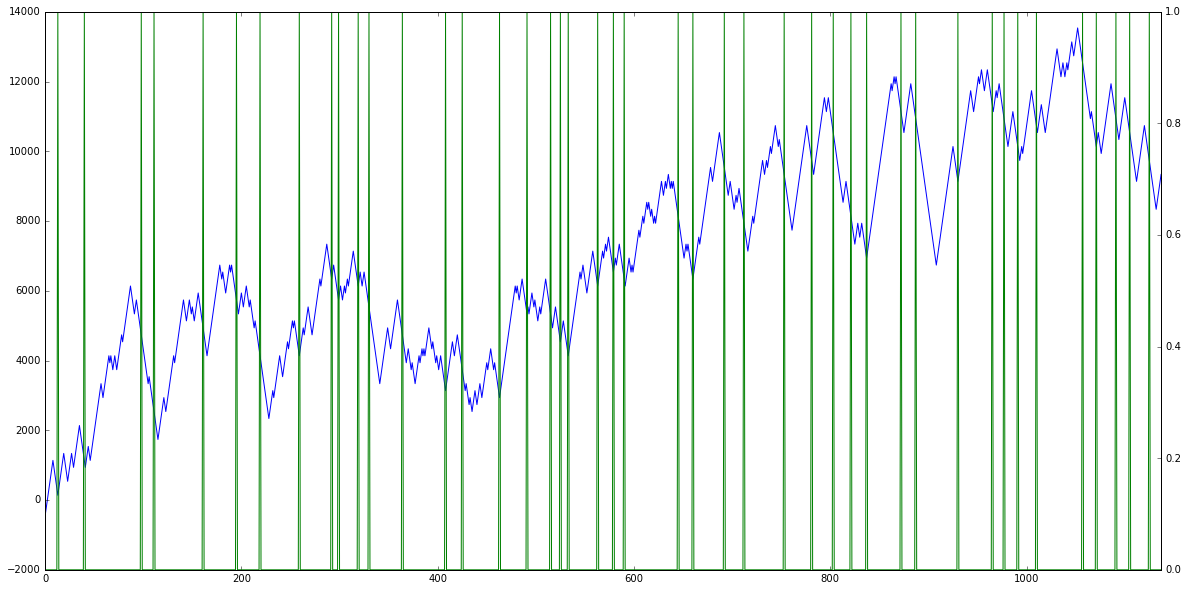

In [572]:
figsize(20,10)
renko_df.close[:].plot()
#renko_df.low[:].plot()

(renko_df.down_count == 5).plot(secondary_y=True)

#renko_df.trend_down.dropna().plot(secondary_y=True)

#renko_df.small_double_bottom.plot(secondary_y=True)
#renko_df.small_double_top.plot(secondary_y=True)

In [574]:
strategyname = 'strategy_440143'
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')

In [575]:
df = pd.DataFrame()
df['close'] = d.exo

In [576]:
#renko_df.index = renko_df.date

df = df.join(renko_df.set_index('date')[['peak','fall','flat','trend_up','trend_down','small_double_bottom',
                                        'small_double_top','up_trend_correction', 'down_trend_correction']])
df = df.fillna(False)

df = df.join(renko_df.set_index('date')[['renko_peak_price_move','renko_fall_price_move']])
df = df.join(renko_df.set_index('date')[['up_count', 'down_count']])
#df = df.join(renko_df.fall, how='right')
#df = df.join(renko_df.flat, how='right')
#df = df.join(renko_df.trend_up)
#df = df.join(renko_df.trend_down)
#df = df.join(renko_df.small_double_bottom)
#df = df.join(renko_df.small_double_top)
#df = df.join(renko_df.up_trend_correction)
#df = df.join(renko_df.down_trend_correction)

#df = df.join(renko_peak_price_move)
#df = df.join(renko_fall_price_move)

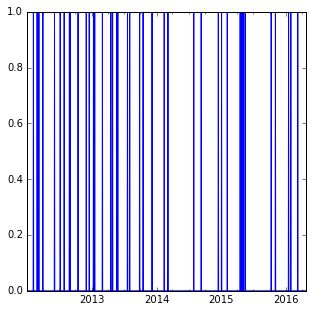

In [571]:
df.peak.groupby(df.peak.index).last().plot()

In [240]:
renko_df.columns

Index(['close', 'date', 'open', 'type', 'low', 'high', 'peak',
       'underlying_peak_price', 'renko_peak_price', 'fall',
       'underlying_fall_price', 'renko_fall_price', 'flat', 'trend_up',
       'trend_down', 'small_double_top', 'small_double_bottom',
       'up_trend_correction', 'down_trend_correction', 'renko_peak_price_move',
       'renko_fall_price_move', 'up_count', 'down_count'],
      dtype='object')

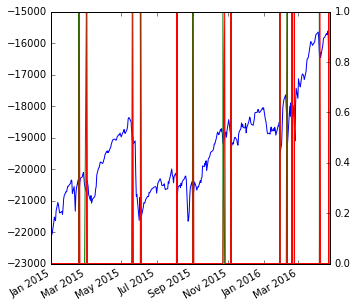

In [457]:
#df = df.fillna(False)
df.close.ix['2015':'2016-04'].plot()
(df.peak == True).ix['2015':'2016-04'].plot(secondary_y=True)

((df.peak == False) & (df.shift(1).peak == True)).ix['2015':'2016-04'].plot(secondary_y=True)
#((df.index != df.index.shift(1, 'D')) & (df.renko_peak_price_move.shift(1) == 'up')).plot(secondary_y=True)
#df.peak.groupby(df.peak.index).last().ix['2015':'2015-04'].plot(secondary_y=True)

In [176]:
df[(df.peak == False) & (df.shift(1).peak == True)]

,close,peak,fall,flat,trend_up,trend_down,small_double_bottom,small_double_top,up_trend_correction,down_trend_correction,renko_peak_price_move,renko_fall_price_move,up_count,down_count
2011-02-07,-1320.0,False,False,False,False,True,False,False,False,False,False,False,0.0,2.0
2011-05-04,7170.0,False,False,False,False,True,False,False,False,False,False,False,0.0,3.0
2011-06-02,3860.0,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0
2011-06-13,1420.0,False,False,False,False,True,False,False,False,False,False,False,0.0,3.0
2011-09-05,-4550.0,False,False,False,False,True,False,False,False,False,down,False,0.0,2.0
2011-09-12,-3600.0,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0
2011-09-20,-3180.0,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0
2011-11-22,-1750.0,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0
2011-12-15,-3310.0,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0
2012-03-29,-3050.0,False,False,False,False,True,False,False,False,False,False,False,0.0,3.0


In [120]:
df[(df.index != df.index.shift(1, 'D')) & (df.renko_peak_price_move.shift(1) == 'same')]

,close,peak,fall,flat,trend_up,trend_down,small_double_bottom,small_double_top,up_trend_correction,down_trend_correction,renko_peak_price_move,renko_fall_price_move
2011-09-09,-3410.0,True,False,False,False,False,False,False,False,False,NaN,NaN
2011-09-12,-3600.0,False,False,False,False,False,False,False,False,False,NaN,NaN
2011-09-20,-3180.0,False,False,False,False,False,False,False,False,False,NaN,NaN
2013-02-15,-3480.0,True,False,False,False,False,False,False,False,False,NaN,NaN
2013-02-18,-3430.0,False,False,False,False,False,False,False,False,False,NaN,NaN
2013-04-03,-3990.0,False,False,False,False,False,False,False,False,False,NaN,NaN
2013-04-03,-3990.0,True,False,False,False,False,False,False,False,False,NaN,NaN
2013-04-03,-3990.0,False,False,False,False,True,False,False,False,False,NaN,NaN
2013-08-07,-290.0,False,False,False,False,False,False,False,False,False,NaN,NaN
2014-06-03,940.0,False,False,False,False,False,False,False,False,False,NaN,NaN


In [172]:
df[(df.index == df.shift(1).index) & (df.peak.shift(1) == True)].ix['2012']

,close,peak,fall,flat,trend_up,trend_down,small_double_bottom,small_double_top,up_trend_correction,down_trend_correction,renko_peak_price_move,renko_fall_price_move,up_count,down_count
2012-03-29,-3050.0,False,False,False,False,True,False,False,False,False,False,False,0.0,3.0
2012-05-03,-4680.0,True,False,False,False,False,False,False,False,False,False,False,0.0,2.0
2012-05-03,-4680.0,True,False,False,False,False,False,False,False,False,False,False,0.0,3.0
2012-05-03,-4680.0,True,False,False,False,False,False,False,False,False,down,False,0.0,1.0
2012-05-03,-4680.0,True,False,False,False,False,False,False,False,False,down,False,0.0,2.0
2012-05-03,-4680.0,True,False,False,False,False,False,False,False,False,down,False,0.0,3.0
2012-05-03,-4680.0,True,False,False,False,False,False,False,False,False,False,False,0.0,1.0
2012-05-03,-4680.0,True,False,False,False,False,False,False,False,False,False,False,0.0,2.0
2012-05-03,-4680.0,True,False,False,False,False,False,False,False,False,False,False,0.0,3.0
2012-05-03,-4680.0,False,False,False,False,True,False,False,False,False,False,False,0.0,1.0


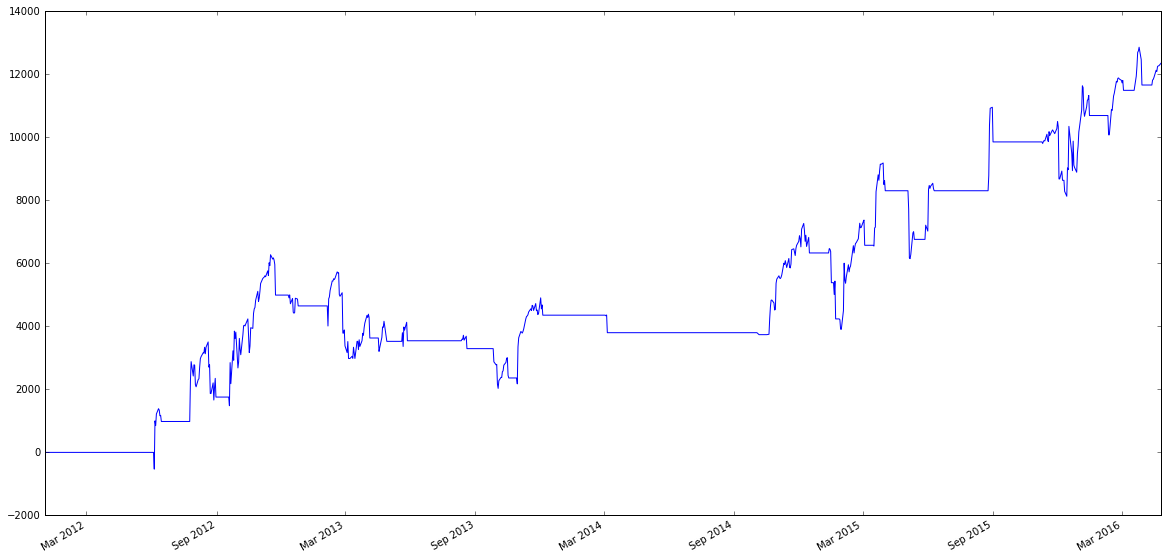

In [652]:
temp_df = d.join(df)

trailing_stop = temp_df.exo.rolling(30).median().shift(1)

short_entry = (temp_df.renko_fall_price_move == 'down')
#short_exit = (temp_df.up_count == )
short_exit = CrossDown(temp_df.exo, trailing_stop)

direction = 1
pl, inposition = backtester.backtest(temp_df, short_entry, short_exit, direction)
equity, stats = backtester.stats(pl, inposition)

equity.plot()

In [653]:
stats

{'avg': 402.1551724137933,
 'avgbarsintrade': 198.72413793103448,
 'avgmae': -287.71551724137936,
 'costs_sum': 0.0,
 'count': 29,
 'maxdd': -4243.7500000000009,
 'netprofit': 11662.500000000005,
 'std': 1277.1051289554357,
 'tradesmaxdd': -2631.2500000000018,
 'winrate': 0.4827586206896552}

In [37]:
df[df.peak == True]

,close,peak,fall,flat,trend_up,trend_down,small_double_bottom,small_double_top,up_trend_correction,down_trend_correction,renko_peak_price_move,renko_fall_price_move,up_count,down_count
2011-01-06,580.0,True,False,False,False,False,False,False,False,False,NaN,NaN,0.0,1.0
2011-01-06,580.0,True,False,False,False,False,False,False,False,False,NaN,NaN,0.0,2.0
2011-01-06,580.0,True,False,False,False,False,False,False,False,False,NaN,NaN,0.0,3.0
2011-01-06,580.0,True,False,False,False,False,False,False,False,False,NaN,NaN,0.0,1.0
2011-01-06,580.0,True,False,False,False,False,False,False,False,False,NaN,NaN,0.0,2.0
2011-01-06,580.0,True,False,False,False,False,False,False,False,False,NaN,NaN,0.0,3.0
2011-01-06,580.0,True,False,False,False,False,False,False,False,False,NaN,NaN,0.0,1.0
2011-01-06,580.0,True,False,False,False,False,False,False,False,False,NaN,NaN,0.0,2.0
2011-01-06,580.0,True,False,False,False,False,False,False,False,False,NaN,NaN,0.0,3.0
2011-01-13,620.0,True,False,False,False,False,False,False,False,False,NaN,NaN,0.0,1.0


In [47]:
d.join(df)

,exo,fut_price,volume,close,peak,fall,flat,trend_up,trend_down,small_double_bottom,small_double_top,up_trend_correction,down_trend_correction,renko_peak_price_move,renko_fall_price_move,up_count,down_count
2011-01-03,2100.0,91930.0,116931,2100.0,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2011-01-04,870.0,89240.0,307960,870.0,False,False,False,False,False,False,False,False,False,NaN,NaN,0.0,0.0
2011-01-04,870.0,89240.0,307960,870.0,False,False,False,False,False,False,False,False,False,NaN,NaN,0.0,1.0
2011-01-04,870.0,89240.0,307960,870.0,False,False,False,False,False,False,False,False,False,NaN,NaN,0.0,2.0
2011-01-04,870.0,89240.0,307960,870.0,False,False,False,False,False,False,False,False,False,NaN,NaN,0.0,3.0
2011-01-04,870.0,89240.0,307960,870.0,False,False,False,False,False,False,False,False,False,NaN,NaN,0.0,4.0
2011-01-04,870.0,89240.0,307960,870.0,False,False,False,False,False,False,False,False,False,NaN,NaN,0.0,5.0
2011-01-04,870.0,89240.0,307960,870.0,False,False,False,False,False,False,False,False,False,NaN,NaN,0.0,0.0
2011-01-04,870.0,89240.0,307960,870.0,False,False,False,False,False,False,False,False,False,NaN,NaN,0.0,1.0
2011-01-04,870.0,89240.0,307960,870.0,False,False,False,False,False,False,False,False,False,NaN,NaN,0.0,2.0
